## 2 Pipeline Horizon Forecast

# Data Understanding

In [19]:
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple, Optional
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, roc_auc_score, f1_score, recall_score,
    precision_score, accuracy_score, brier_score_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import BaseEstimator, TransformerMixin
import sklearn

RANDOM_STATE = 42

def safe_onehot(min_freq: int = 50):
    """OneHotEncoder with rare-category bucketing if supported."""
    if sklearn.__version__ >= "1.1":
        return OneHotEncoder(handle_unknown="ignore", min_frequency=min_freq, sparse_output=True)
    return OneHotEncoder(handle_unknown="ignore", sparse=True)

def summarize_metrics(y_true, y_prob, y_pred, title=""):
    print(f"\n=== {title} ===")
    print(classification_report(y_true, y_pred, digits=3))
    print("ROC-AUC:", roc_auc_score(y_true, y_prob))
    print("Brier score (lower is better):", brier_score_loss(y_true, y_prob))
    return {
        "f1": f1_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "accuracy": accuracy_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_prob),
        "brier": brier_score_loss(y_true, y_prob)
    }



In [20]:
# Load data into pandas data frame
flight_df = pd.read_csv("../Data/DelayedFlights.csv")

# Show initial data
flight_df.info()
flight_df.head(10)
flight_df.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936758 entries, 0 to 1936757
Data columns (total 30 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   Year               int64  
 2   Month              int64  
 3   DayofMonth         int64  
 4   DayOfWeek          int64  
 5   DepTime            float64
 6   CRSDepTime         int64  
 7   ArrTime            float64
 8   CRSArrTime         int64  
 9   UniqueCarrier      object 
 10  FlightNum          int64  
 11  TailNum            object 
 12  ActualElapsedTime  float64
 13  CRSElapsedTime     float64
 14  AirTime            float64
 15  ArrDelay           float64
 16  DepDelay           float64
 17  Origin             object 
 18  Dest               object 
 19  Distance           int64  
 20  TaxiIn             float64
 21  TaxiOut            float64
 22  Cancelled          int64  
 23  CancellationCode   object 
 24  Diverted           int64  
 25  CarrierDelay      

(1936758, 30)

## Data Preparation

In [21]:
# Drop duplicate rows if any
flight_df = flight_df.drop_duplicates()

# Drop irrelevant columns
flight_df.drop(columns=["Unnamed: 0", "TailNum", "FlightNum"], inplace=True, errors="ignore")

# Remove cancelled or diverted flights
flight_df = flight_df[(flight_df["Cancelled"] == 0) & (flight_df["Diverted"] == 0)]

# Fill delay cause NaNs with 0
delay_cols = ["CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"]
flight_df[delay_cols] = flight_df[delay_cols].fillna(0)

# Drop rows with missing critical values
flight_df.dropna(subset=["ArrDelay", "DepDelay", "ArrTime", "DepTime"], inplace=True)

# Create target variable (1 if delayed ≥ 15 min, else 0)
flight_df["DELAYED"] = (flight_df["ArrDelay"] >= 15).astype(int)

# Extract scheduled departure/arrival hour
flight_df["CRSDepHour"] = flight_df["CRSDepTime"].astype(str).str.zfill(4).str[:2].astype(int)
flight_df["CRSArrHour"] = flight_df["CRSArrTime"].astype(str).str.zfill(4).str[:2].astype(int)

# Add simple time features
flight_df["IsWeekend"] = flight_df["DayOfWeek"].isin([6, 7]).astype(int)
flight_df["IsHolidaySeason"] = flight_df["Month"].isin([11, 12]).astype(int)
flight_df["IsPeak"] = flight_df["CRSDepHour"].isin([6,7,8,16,17,18,19]).astype(int)

# Create route feature
flight_df["Route"] = flight_df["Origin"].astype(str).str.cat(flight_df["Dest"].astype(str), sep="_")

# Create distance bands
flight_df["DistanceBand"] = pd.cut(
    flight_df["Distance"],
    bins=[-np.inf, 300, 800, 1500, np.inf],
    labels=["short", "medium", "long", "ultra"]
)

# Convert categorical columns
for col in ["UniqueCarrier", "Origin", "Dest", "CancellationCode", "Route", "DistanceBand"]:
    if col in flight_df.columns:
        flight_df[col] = flight_df[col].astype("category")

print("Cleaned shape:", flight_df.shape)

Cleaned shape: (1928371, 35)


## Data Exploration

In [22]:
# target variable
flight_df["DELAYED"] = (flight_df["ArrDelay"] >= 15).astype(int)
flight_df["DELAYED"].value_counts(normalize=True)

DELAYED
1    0.646913
0    0.353087
Name: proportion, dtype: float64

<Axes: xlabel='ArrDelay', ylabel='Count'>

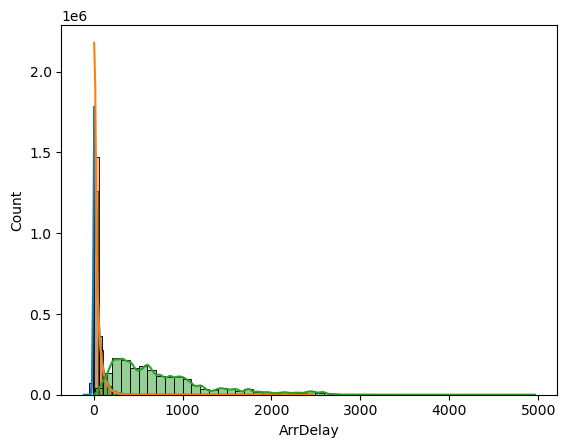

In [23]:
sns.histplot(flight_df["ArrDelay"].dropna(), bins=50, kde=True)
sns.histplot(flight_df["DepDelay"].dropna(), bins=50, kde=True)
sns.histplot(flight_df["Distance"], bins=50, kde=True)

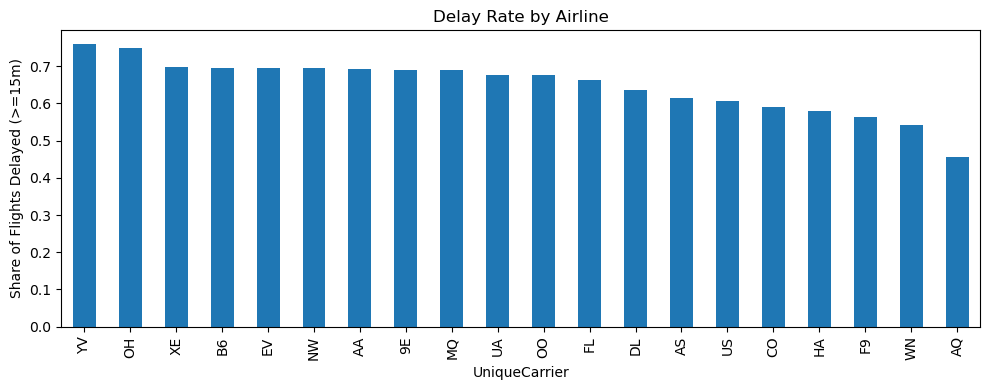

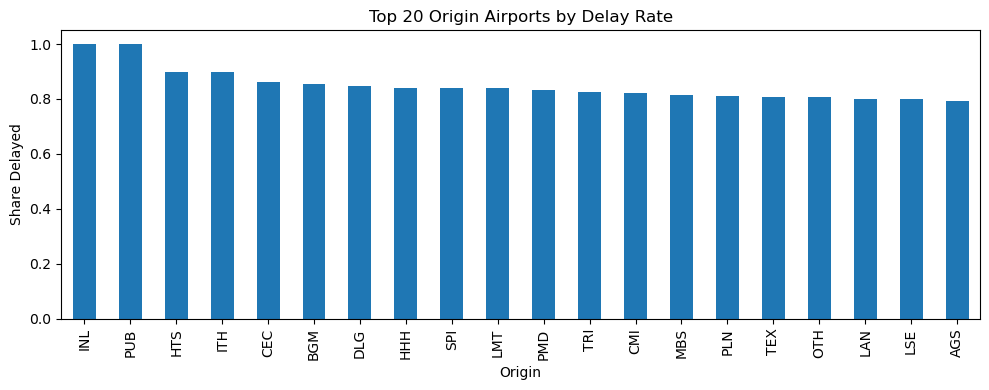

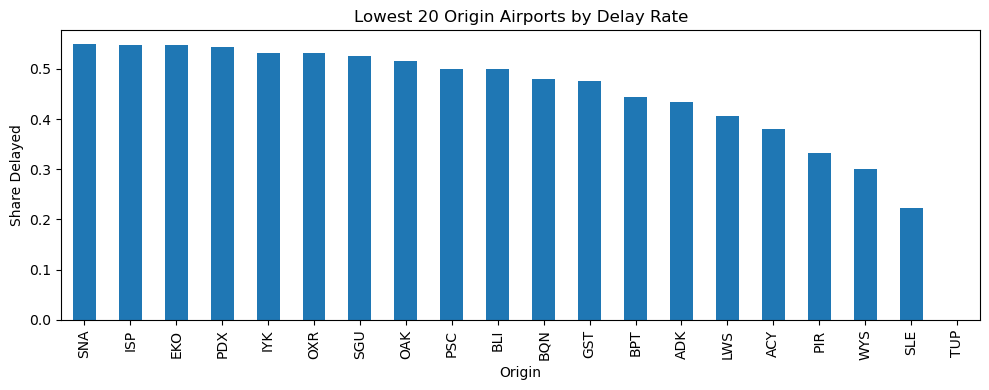

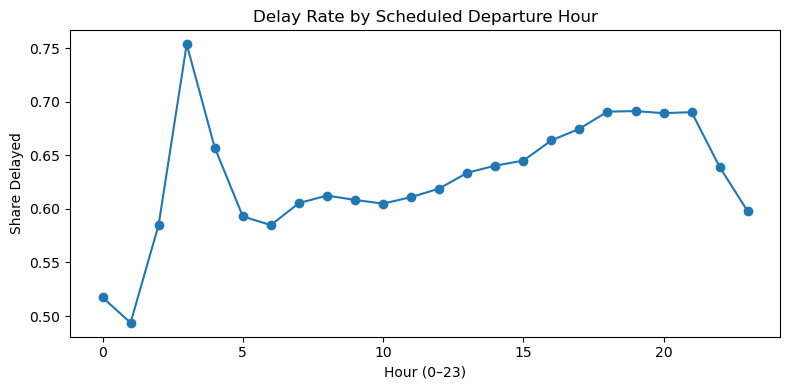

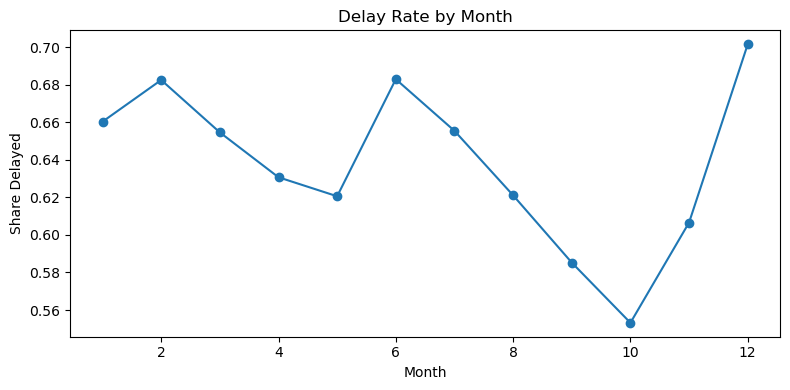

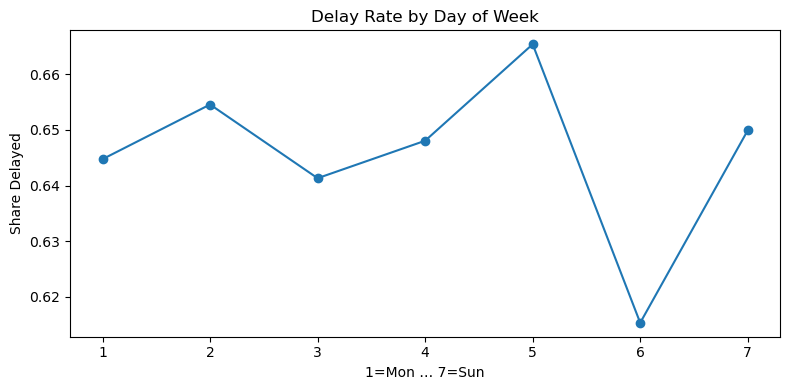

In [ ]:
# Delay rates by airline
carrier_col = "UniqueCarrier"
airline_delay = (flight_df
                 .groupby(carrier_col, observed=True)["DELAYED"]
                 .mean()
                 .sort_values(ascending=False))
airline_delay.plot(kind="bar", title="Delay Rate by Airline", figsize=(10,4))
plt.ylabel("Share of Flights Delayed (>=15m)")
plt.tight_layout(); plt.show()

# Delay rates by airport
origin_delay = (flight_df
                .groupby("Origin", observed=True)["DELAYED"]
                .mean()
                .sort_values(ascending=False))
origin_delay.head(20).plot(kind="bar", title="Top 20 Origin Airports by Delay Rate", figsize=(10,4))
plt.ylabel("Share Delayed"); plt.tight_layout(); plt.show()

origin_delay.tail(20).plot(kind="bar", title="Lowest 20 Origin Airports by Delay Rate", figsize=(10,4))
plt.ylabel("Share Delayed"); plt.tight_layout(); plt.show()

# Delay rates by hour
if "CRSDepHour" not in flight_df.columns and "CRSDepTime" in flight_df.columns:
    flight_df["CRSDepHour"] = flight_df["CRSDepTime"].astype(str).str.zfill(4).str[:2].astype(int)
hour_delay = (flight_df
              .groupby("CRSDepHour", observed=True)["DELAYED"]
              .mean()
              .sort_index())
hour_delay.plot(marker="o", title="Delay Rate by Scheduled Departure Hour", figsize=(8,4))
plt.ylabel("Share Delayed"); plt.xlabel("Hour (0-23)")
plt.tight_layout(); plt.show()

# Delay rate by month and day-of-week
month_delay = (flight_df.groupby("Month", observed=True)["DELAYED"]
               .mean().sort_index())
month_delay.plot(marker="o", title="Delay Rate by Month", figsize=(8,4))
plt.ylabel("Share Delayed"); plt.xlabel("Month")
plt.tight_layout(); plt.show()

dow_delay = (flight_df.groupby("DayOfWeek", observed=True)["DELAYED"]
             .mean().sort_index())
dow_delay.plot(marker="o", title="Delay Rate by Day of Week", figsize=(8,4))
plt.ylabel("Share Delayed"); plt.xlabel("1=Mon … 7=Sun")
plt.tight_layout(); plt.show()

<Axes: title={'center': 'Total Delay Minutes by Cause'}>

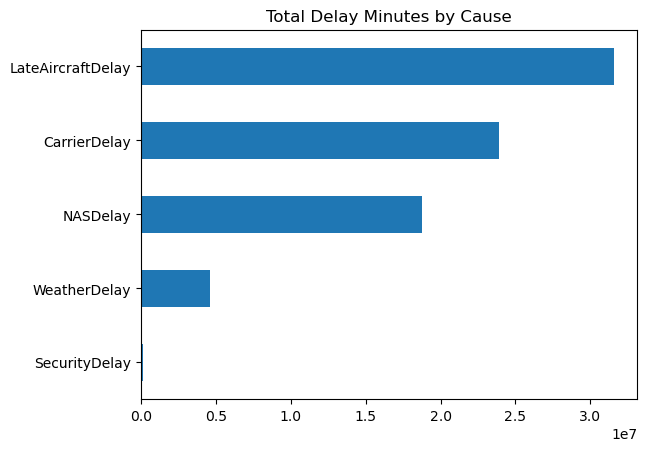

In [25]:
# Delay cause
cause_cols = ["CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"]
flight_df[cause_cols].sum().sort_values().plot(kind="barh", title="Total Delay Minutes by Cause")

C:\Users\ryans\AppData\Local\Temp\ipykernel_3488\1536324579.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = pd.pivot_table(flight_df, values="DELAYED", index="UniqueCarrier", columns="Month", aggfunc="mean")


<Axes: xlabel='Month', ylabel='UniqueCarrier'>

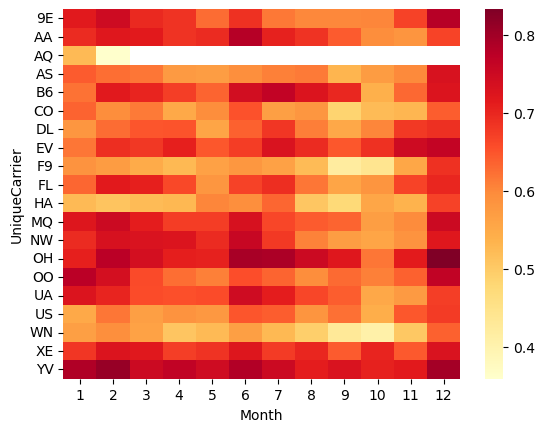

In [26]:
# Heatmap of airline × month
pivot = pd.pivot_table(flight_df, values="DELAYED", index="UniqueCarrier", columns="Month", aggfunc="mean")
sns.heatmap(pivot, annot=False, cmap="YlOrRd")

In [27]:
# Required columns for creating the target if not present
ARR_DELAY_CANDS = ["ArrDelay", "arr_delay", "arrdelay"]
CARRIER_CANDS   = ["UniqueCarrier", "Airline", "Carrier", "AIRLINE", "Unique_Carrier"]
MONTH_CANDS     = ["Month", "MONTH", "month"]
DOW_CANDS       = ["DayOfWeek", "Day_of_Week", "DOW"]
HOUR_CANDS      = ["CRSDepTime", "CRSDepHour", "SchedDepHour", "DepHour"]
ORIGIN_CANDS    = ["Origin", "ORIGIN", "origin"]
DEST_CANDS      = ["Dest", "DEST", "dest"]
DIST_CANDS      = ["Distance", "DISTANCE", "distance"]

LEAKAGE_COLS = [
    "ArrDelay", "DepDelay", "Cancelled", "Diverted",
    "CarrierDelay", "WeatherDelay", "NASDelay",
    "SecurityDelay", "LateAircraftDelay"
]

def find_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    low = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in low:
            return low[cand.lower()]
    return None

def ensure_target(df: pd.DataFrame) -> Tuple[pd.DataFrame, str]:
    target = find_col(df, ["DELAYED", "IsDelayed", "dep_delayed_15min"])
    if target is None:
        arr = find_col(df, ARR_DELAY_CANDS)
        if arr is None:
            raise KeyError("No target column found and no ArrDelay-like column to derive it.")
        df = df.copy()
        df["DELAYED"] = (df[arr] >= 15).astype(int)
        target = "DELAYED"
    return df, target

# Create X, y from original DataFrame (e.g., flight_df)
df0, TARGET = ensure_target(flight_df)
df0 = df0.drop(columns=LEAKAGE_COLS, errors="ignore")


In [28]:
# Columns expected to be known 6+ months in advance (STRUCTURAL)
STRUCTURAL_FEATS = [
    # Categorical
    find_col(df0, CARRIER_CANDS),
    find_col(df0, ORIGIN_CANDS),
    find_col(df0, DEST_CANDS),
    # Time bins derived from schedule (create if raw times present)
    find_col(df0, MONTH_CANDS),
    find_col(df0, DOW_CANDS),
    find_col(df0, HOUR_CANDS),
    # Numeric
    find_col(df0, DIST_CANDS),
]
STRUCTURAL_FEATS = [c for c in STRUCTURAL_FEATS if c is not None]

# Additional day-of, real-time signals (add what you have)
REALTIME_EXTRA_FEATS = [
    # e.g., these columns if present in your merged dataset:
    "WeatherSeverity_Dep",    # engineered score or categorical bins
    "WeatherSeverity_Arr",
    "InboundDelay15",         # binary: inbound aircraft late?
    "TrafficLoad_Dep",        # congestion indicator
    "TrafficLoad_Arr"
]
REALTIME_FEATS = list(dict.fromkeys(STRUCTURAL_FEATS + [c for c in REALTIME_EXTRA_FEATS if c in df0.columns]))


In [29]:
X_all = df0.drop(columns=[TARGET], errors="ignore")
y_all = df0[TARGET].astype(int)

# Use only the columns available per horizon
X_struct = X_all[STRUCTURAL_FEATS].copy()
X_real   = X_all[REALTIME_FEATS].copy()  # real-time superset

# Split once to create a consistent benchmark across horizons
X_train_s, X_temp_s, y_train_s, y_temp_s = train_test_split(
    X_struct, y_all, test_size=0.3, stratify=y_all, random_state=RANDOM_STATE
)
X_valid_s, X_test_s, y_valid_s, y_test_s = train_test_split(
    X_temp_s, y_temp_s, test_size=0.5, stratify=y_temp_s, random_state=RANDOM_STATE
)

X_train_r, X_temp_r, y_train_r, y_temp_r = train_test_split(
    X_real, y_all, test_size=0.3, stratify=y_all, random_state=RANDOM_STATE
)
X_valid_r, X_test_r, y_valid_r, y_test_r = train_test_split(
    X_temp_r, y_temp_r, test_size=0.5, stratify=y_temp_r, random_state=RANDOM_STATE
)


## Real-Time and Structural Pipelines

In [30]:
def build_preprocessor(X: pd.DataFrame) -> ColumnTransformer:
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", safe_onehot(min_freq=50)),
    ])
    # For trees, scaling is optional; for linear models, keep with_mean=False
    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler(with_mean=False)),
    ])
    return ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop",
        sparse_threshold=0.3
    )

preprocess_struct = build_preprocessor(X_train_s)
preprocess_real   = build_preprocessor(X_train_r)


In [31]:
# Logistic Regression (sparse-friendly) + probability calibration
struct_base = Pipeline(steps=[
    ("prep", preprocess_struct),
    ("clf", LogisticRegression(
        solver="saga",
        penalty="l2",
        C=0.5,
        tol=1e-3,
        max_iter=4000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

# Calibrate on validation set (isotonic is flexible; sigmoid is faster)
struct_base.fit(X_train_s, y_train_s)
struct_calib = CalibratedClassifierCV(struct_base, cv="prefit", method="isotonic")
struct_calib.fit(X_valid_s, y_valid_s)


c:\Users\ryans\anaconda3\envs\ml_env\lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


,estimator,Pipeline(step... tol=0.001))])
,method,'isotonic'
,cv,'prefit'
,n_jobs,None
,ensemble,'auto'
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [32]:
try:
    import xgboost as xgb
    xgb_ok = True
except Exception:
    xgb_ok = False

if xgb_ok:
    real_model = Pipeline(steps=[
        ("prep", preprocess_real),
        ("clf", xgb.XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",
            device="cuda",      # use GPU if available; otherwise remove this line
            n_estimators=600,
            max_depth=8,
            learning_rate=0.05,
            subsample=0.85,
            colsample_bytree=0.85,
            reg_lambda=1.0,
            random_state=RANDOM_STATE
        ))
    ])
else:
    # Fallback: Gradient Boosting / Random Forest if xgboost not installed
    from sklearn.ensemble import RandomForestClassifier
    real_model = Pipeline(steps=[
        ("prep", preprocess_real),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            max_depth=20,
            class_weight="balanced",
            n_jobs=-1,
            random_state=RANDOM_STATE
        ))
    ])

real_model.fit(X_train_r, y_train_r)
# Optional: further calibrate real-time model as well (often improves probability quality)
real_calib = CalibratedClassifierCV(real_model, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE), method="isotonic")
real_calib.fit(X_valid_r, y_valid_r)



c:\Users\ryans\anaconda3\envs\ml_env\lib\site-packages\xgboost\core.py:729: UserWarning: [12:06:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


,estimator,"Pipeline(step...=None, ...))])"
,method,'isotonic'
,cv,StratifiedKFo... shuffle=True)
,n_jobs,None
,ensemble,'auto'
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [33]:
# Structural horizon
p_s = struct_calib.predict_proba(X_test_s)[:, 1]
yhat_s = (p_s >= 0.5).astype(int)
metrics_struct = summarize_metrics(y_test_s, p_s, yhat_s, title="Structural Model (6+ months)")

# Real-time horizon
p_r = real_calib.predict_proba(X_test_r)[:, 1]
yhat_r = (p_r >= 0.5).astype(int)
metrics_real = summarize_metrics(y_test_r, p_r, yhat_r, title="Real-Time Model (Day-of)")

# Optional: tune thresholds by business objective (maximize F1 or set minimum precision/recall)
def best_threshold(y_true, y_prob, metric="f1"):
    ts = np.linspace(0.05, 0.95, 19)
    scores = []
    for t in ts:
        pred = (y_prob >= t).astype(int)
        if metric == "f1":
            scores.append((t, f1_score(y_true, pred)))
        elif metric == "recall":
            scores.append((t, recall_score(y_true, pred)))
        elif metric == "precision":
            scores.append((t, precision_score(y_true, pred)))
    return max(scores, key=lambda x: x[1])

t_s, score_s = best_threshold(y_test_s, p_s, metric="f1")
t_r, score_r = best_threshold(y_test_r, p_r, metric="f1")
print(f"\nSuggested thresholds (by F1): structural={t_s:.2f}, real-time={t_r:.2f}")



=== Structural Model (6+ months) ===
              precision    recall  f1-score   support

           0      0.551     0.113     0.187    102133
           1      0.662     0.950     0.780    187123

    accuracy                          0.654    289256
   macro avg      0.607     0.531     0.484    289256
weighted avg      0.623     0.654     0.571    289256

ROC-AUC: 0.6141910127568888
Brier score (lower is better): 0.2198834256050608

=== Real-Time Model (Day-of) ===
              precision    recall  f1-score   support

           0      0.577     0.185     0.280    102133
           1      0.675     0.926     0.781    187123

    accuracy                          0.664    289256
   macro avg      0.626     0.555     0.531    289256
weighted avg      0.641     0.664     0.604    289256

ROC-AUC: 0.6535442053391617
Brier score (lower is better): 0.21313684350564355

Suggested thresholds (by F1): structural=0.40, real-time=0.40


## Set-up for horizon predictions

In [ ]:
# Drop leakage columns that wouldn't be known at prediction time
LEAKAGE_COLS = [
    "ArrDelay", "DepDelay", "Cancelled", "Diverted",
    "CarrierDelay", "WeatherDelay", "NASDelay",
    "SecurityDelay", "LateAircraftDelay",
    "DepTime", "ArrTime", "ActualElapsedTime", "AirTime", "TaxiIn", "TaxiOut"
]
base_df = flight_df.drop(columns=LEAKAGE_COLS, errors="ignore")


In [40]:
# Helper: safe groupby mean
def gb_mean(df, by, col="DELAYED", name="p_delay"):
    out = (df.groupby(by, observed=False)[col]
             .mean()
             .reset_index()
             .rename(columns={col: name}))
    return out

# (a) Route × Month delay rate
route_month_delay_rate = gb_mean(base_df, ["Origin", "Dest", "Month"])

# (b) Carrier × Month delay rate
carrier_month_delay_rate = gb_mean(base_df, ["UniqueCarrier", "Month"])

# (c) Origin × Scheduled Hour congestion proxy (from CRSDepTime hour)
#     Derive scheduled hour from CRSDepTime (HHMM integer)
hr = (base_df["CRSDepTime"] // 100).clip(0, 23).astype(int)
tmp = base_df.assign(SchedDepHour=hr)
origin_hour_congestion = (tmp.groupby(["Origin", "SchedDepHour"], observed=False)
                            .size()
                            .reset_index(name="congestion_idx"))
# Normalize congestion to [0,1] per origin (optional but useful)
origin_hour_congestion["congestion_idx"] = (
    origin_hour_congestion.groupby("Origin", observed=False)["congestion_idx"]
    .transform(lambda s: (s - s.min()) / (s.max() - s.min() + 1e-9))
)

# Put into a lookups dict
lookups = {
    "route_month_delay_rate": route_month_delay_rate,     # columns: Origin, Dest, Month, p_delay
    "carrier_month_delay_rate": carrier_month_delay_rate, # columns: UniqueCarrier, Month, p_delay
    "origin_hour_congestion": origin_hour_congestion,     # columns: Origin, SchedDepHour, congestion_idx
}


In [41]:
def _coerce_hour_from_crsdep(CRSDepTime):
    """Convert HHMM int to hour [0..23]."""
    if pd.isna(CRSDepTime):
        return np.nan
    v = int(CRSDepTime)
    return max(0, min(23, v // 100))

def make_horizon_row(base: dict, horizon: str, lookups: dict) -> pd.DataFrame:
    """
    base: {
      "UniqueCarrier": str, "Origin": str, "Dest": str,
      "Month": int, "DayOfWeek": int, "CRSDepTime": int (HHMM), "Distance": int,
      # (optionally you can add dynamic features in the future)
    }
    """
    row = dict(base)
    df = pd.DataFrame([row])

    # Derive SchedDepHour from CRSDepTime for joining congestion proxy
    if "CRSDepTime" in df.columns:
        df["SchedDepHour"] = df["CRSDepTime"].apply(_coerce_hour_from_crsdep)
    else:
        df["SchedDepHour"] = np.nan

    # Merge structural proxies
    if not lookups["route_month_delay_rate"].empty:
        df = df.merge(
            lookups["route_month_delay_rate"],
            on=["Origin", "Dest", "Month"], how="left"
        ).rename(columns={"p_delay": "RouteMonthDelayRate"})

    if not lookups["carrier_month_delay_rate"].empty:
        df = df.merge(
            lookups["carrier_month_delay_rate"],
            on=["UniqueCarrier", "Month"], how="left"
        ).rename(columns={"p_delay": "CarrierMonthDelayRate"})

    if not lookups["origin_hour_congestion"].empty:
        df = df.merge(
            lookups["origin_hour_congestion"],
            on=["Origin", "SchedDepHour"], how="left"
        )

    # Near-term placeholders (if you later add dynamic inputs)
    dyn_cols = ["WeatherSeverity_Dep","WeatherSeverity_Arr","InboundDelay15",
                "TrafficLoad_Dep","TrafficLoad_Arr"]
    if horizon in ("1w","2w"):
        for c in dyn_cols:
            if c not in df.columns:
                df[c] = np.nan
    else:
        # far horizons: ensure dynamics are NaN
        for c in dyn_cols:
            if c in df.columns:
                df[c] = np.nan

    return df


# Horizons Predictions

In [56]:
# --- Horizon config (adjust as needed) ---
horizons = ["1w", "2w", "1m", "3m", "6m"]
models = {
    "1w": struct_calib,      # short-term logistic regression (example)
    "2w": struct_calib,
    "1m": real_calib,         # long-term XGBoost (example)
    "3m": real_calib,
    "6m": real_calib,
}

thresholds = {"1w": 0.50, "2w": 0.50, "1m": 0.55, "3m": 0.57, "6m": 0.60}
conf_labels = {"1w": "High", "2w": "Moderately High", "1m": "Moderate", "3m": "Low–Moderate", "6m": "Low"}
conf_bands  = {"1w": 0.05, "2w": 0.07, "1m": 0.10, "3m": 0.12, "6m": 0.15}  # ± probability band
decay       = {"1w": 1.00, "2w": 0.90, "1m": 0.60, "3m": 0.45, "6m": 0.3}

# models = { "1w": real_calib, "2w": real_calib, "1m": struct_calib, "3m": struct_calib, "6m": struct_calib }
# lookups built earlier; make_horizon_row defined earlier

def predict_with_decay(horizon: str, base_flight: dict, thresholds: dict, decay: dict):
    """Build horizon-specific features, run model, apply decay toward 0.5, and return display-ready dict."""
    model = models[horizon]
    thr   = thresholds.get(horizon, 0.5)
    band  = conf_bands.get(horizon, 0.1)
    label = conf_labels.get(horizon, "Unknown")
    df_h  = make_horizon_row(base_flight, horizon, lookups)

    # Raw probability from model
    p_raw = float(model.predict_proba(df_h)[:, 1][0])
    # Decay toward 0.3 to reflect uncertainty at longer horizons
    k     = decay.get(horizon, 1.0)
    p_adj = (p_raw - 0.5) * k + 0.5
    p_adj = max(0.0, min(1.0, p_adj))

    pred = int(p_adj >= thr)
    lo   = round(max(0.0, p_adj - band), 3)
    hi   = round(min(1.0, p_adj + band), 3)

    return {
        "pred": pred,
        "prob": round(p_adj, 3),                 # adjusted probability (shown in your printout)
        "prob_raw": round(p_raw, 3),             # optional: keep raw for inspection
        "threshold": float(thr),
        "confidence_label": label,
        "confidence_interval": [lo, hi],
        "decay_factor": k
    }


# Sample a few rows
sampled_rows = base_df.sample(n=10, random_state=42)

# Score each sampled row across horizons
sample_results = {}
for idx, row in sampled_rows.iterrows():
    base_flight = {
        "UniqueCarrier": row["UniqueCarrier"],
        "Origin": row["Origin"],
        "Dest": row["Dest"],
        "Month": int(row["Month"]),
        "DayOfWeek": int(row["DayOfWeek"]),
        "CRSDepTime": int(row["CRSDepTime"]),
        "Distance": int(row["Distance"]),
    }
    preds = {h: predict_with_decay(h, base_flight, thresholds, decay) for h in horizons}
    sample_results[idx] = {"input": base_flight, "predictions": preds}

# Pretty-print
for idx, info in sample_results.items():
    print(f"\n=== Flight {idx} ===")
    print("Input:", info["input"])
    for h, r in info["predictions"].items():
        ci = f"[{r['confidence_interval'][0]:.2f}, {r['confidence_interval'][1]:.2f}]"
        print(f" {h:>3} → pred={r['pred']} prob={r['prob']:.3f} thr={r['threshold']:.2f} "
              f"conf={r['confidence_label']} band={ci}  (raw={r.get('prob_raw', r['prob']):.3f}, k={r['decay_factor']})")



=== Flight 403778 ===
Input: {'UniqueCarrier': 'WN', 'Origin': 'STL', 'Dest': 'MDW', 'Month': 3, 'DayOfWeek': 2, 'CRSDepTime': 1115, 'Distance': 251}
  1w → pred=1 prob=0.552 thr=0.50 conf=High band=[0.50, 0.60]  (raw=0.552, k=1.0)
  2w → pred=1 prob=0.547 thr=0.50 conf=Moderately High band=[0.48, 0.62]  (raw=0.552, k=0.9)
  1m → pred=0 prob=0.528 thr=0.55 conf=Moderate band=[0.43, 0.63]  (raw=0.547, k=0.6)
  3m → pred=0 prob=0.521 thr=0.57 conf=Low–Moderate band=[0.40, 0.64]  (raw=0.547, k=0.45)
  6m → pred=0 prob=0.514 thr=0.60 conf=Low band=[0.36, 0.66]  (raw=0.547, k=0.3)

=== Flight 1397595 ===
Input: {'UniqueCarrier': 'AA', 'Origin': 'DFW', 'Dest': 'MIA', 'Month': 8, 'DayOfWeek': 6, 'CRSDepTime': 1130, 'Distance': 1121}
  1w → pred=1 prob=0.626 thr=0.50 conf=High band=[0.58, 0.68]  (raw=0.626, k=1.0)
  2w → pred=1 prob=0.613 thr=0.50 conf=Moderately High band=[0.54, 0.68]  (raw=0.626, k=0.9)
  1m → pred=0 prob=0.530 thr=0.55 conf=Moderate band=[0.43, 0.63]  (raw=0.550, k=0.6)
  

# Horizons Heatmap

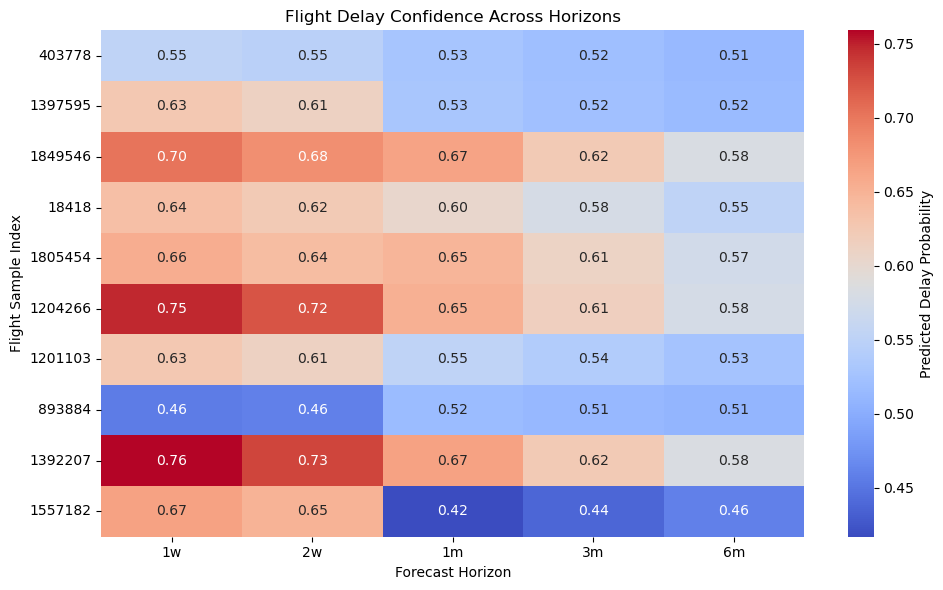

In [57]:
horizons = ["1w", "2w", "1m", "3m", "6m"]
records = []
for idx, row in sampled_rows.iterrows():
    base_flight = {
        "UniqueCarrier": row["UniqueCarrier"],
        "Origin": row["Origin"],
        "Dest": row["Dest"],
        "Month": int(row["Month"]),
        "DayOfWeek": int(row["DayOfWeek"]),
        "CRSDepTime": int(row["CRSDepTime"]),
        "Distance": int(row["Distance"])
    }
    preds = {h: predict_with_decay(h, base_flight, thresholds, decay) for h in horizons}
    record = {"FlightIdx": idx}
    for h in horizons:
        record[h] = preds[h]["prob"]
    records.append(record)
heatmap_df = pd.DataFrame(records).set_index("FlightIdx")

# 5) Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "Predicted Delay Probability"})
plt.title("Flight Delay Confidence Across Horizons")
plt.ylabel("Flight Sample Index")
plt.xlabel("Forecast Horizon")
plt.tight_layout()
plt.show()